### This notebook is to build the content based recommender system, which can recommend the most X number of similar articles to the readers based on their current reading/recent searched/liked article

In [62]:
import pandas as pd
import string
import bs4
from bs4 import BeautifulSoup
import unicodedata
import re 
import os
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import numpy as np
from nltk.corpus import brown
from nltk.corpus import wordnet
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import trange
import matplotlib.pyplot as plt
import collections

pd.options.display.max_colwidth = 1000

## Prepare Dataset

In [2]:
dirname=os.path.dirname

In [3]:
file_path = os.path.join(dirname(dirname(os.path.abspath(''))), "project_data//data//raw//unlabeled_dataset_40K.xlsx")

In [4]:
class DataPipeline():
    def __int__(self):
        self.cont = Contractions('..//data//GoogleNews-vectors-negative300.bin')
        self.cont.load_models()

        
    @staticmethod
    def remove_digits(text):
        pattern = '[0-9]'
        processed_text = re.sub(pattern, '', text)
        return processed_text
        
    @staticmethod
    def to_lowercase(text):
        return text.lower()

    # remove punctuations
    @staticmethod
    def remove_punctuation(text):
        processed_text = ''.join([c for c in text if c not in string.punctuation]) 
        return processed_text
    
    @staticmethod
    def remove_html(text):
        processed_text = BeautifulSoup(text, 'html.parser').get_text()
        return processed_text

    @staticmethod
    def replace_accented_chars(text):
        processed_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore') # it encodes a unicode string to ascii and ignores errors, then decode ascii to utf-8
        return processed_text

    @staticmethod
    def remove_artefacts(text):
        processed_text = re.sub("(\t)+", " ", text) # remove \t
        processed_text = re.sub("(\n)+", " ", processed_text) # remove \n
        processed_text = re.sub("\[|\]", " ", processed_text) # remove []
        return processed_text

    @staticmethod
    def clean_extra_space(text):
        processed_text = re.sub(" +", " ", text) # replace multiple spaces with single space
        return processed_text 

    @staticmethod
    def remove_stopwords(text):
        wordnet_lemmatizer = WordNetLemmatizer()
        tokenizer = ToktokTokenizer()
        stopword_list = nltk.corpus.stopwords.words('english')
        tokens = tokenizer.tokenize(text)
        tokens = [token.strip() for token in tokens]
        text = [wordnet_lemmatizer.lemmatize(token, pos="n") for token in tokens if token not in stopword_list]
        text = [wordnet_lemmatizer.lemmatize(token, pos="v") for token in text]
        return text
    
    '''
    @staticmethod
    def expand_contractions(text):
        processed_text = list(self.cont.expand_texts([text], precise=True))[0]
        return processed_text
    '''
    
    def load_data(self, data_path):
        df = pd.read_excel(data_path, engine='openpyxl', header=0, usecols=["body"])
        self.df = df
        
    def process_data(self):
        self.df["body"] = self.df.body.apply(lambda x: self.remove_digits(x))
        self.df["body"] = self.df.body.apply(lambda x: self.to_lowercase(x))
        self.df["body"] = self.df.body.apply(lambda x: self.remove_punctuation(x))
        self.df["body"] = self.df.body.apply(lambda x: self.remove_html(x))
        self.df["body"] = self.df.body.apply(lambda x: self.replace_accented_chars(x))
        self.df["body"] = self.df.body.apply(lambda x: self.remove_artefacts(x))
        self.df["body"] = self.df.body.apply(lambda x: self.clean_extra_space(x))
        self.df["body"] = self.df.body.apply(lambda x: self.remove_stopwords(x))
        # self.df["body"] = self.df.body.apply(lambda x: self.expand_contractions(x)) # remove expanding due to time concern
        return self.df

In [5]:
dp = DataPipeline()

In [6]:
dp.load_data(file_path)

In [7]:
cleaned_data = dp.process_data()

In [8]:
cleaned_data

body
0                                                                                                                                                       [ngawang, nyima, water, plant, residence, qamdo, city, southwest, china, tibet, autonomous, region, feb, ngawang, nyima, bear, naixi, township, mangkam, county, qamdo, city, southwest, china, tibet, autonomous, region, use, serf, lade, heavy, tax, start, herd, sheep, landlord, eight, year, old, force, fetch, bittern, salt, pan, lancang, river, trail, salt, pan, precipitous, single, careless, step, would, spill, one, rapid, wave, river, ngawang, nyima, join, militia, kasha, government, otherwise, would, execute, immediately, disobedience, fortunately, survive, front, onslaught, fight, thank, father, hide, inside, obsolete, house, liberate, ngawang, nyima, serve, head, village, committee, lead, neighbor, build, water, duct, improve, arable, land, instead, shabby, leak, wooden, ...]
1                                                                                                   [chinese, telecom, giant, huawei, initiate, new, public, service, campaign, thursday, aim, plant, tree, donate, company, consumer, across, desert, locate, china, northwestern, gansu, province, richard, yu, head, huaweis, consumer, business, announce, company, donate, desert, poplar, gansu, jinta, county, admire, dazzle, color, desert, poplar, also, tenacity, yu, say, open, ceremony, campaign, entitle, desert, poplar, forest, gansu, yu, continue, huawei, hope, leave, legacy, mountain, stream, behalf, generation, contribute, environmental, protection, dub, desert, hero, desert, poplar, highly, resilient, able, survive, dreadful, condition, plant, play, vital, role, maintain, ecological, balance, improve, soil, slow, desertification, huawei, commit, environmental, protection, decade, tech, giant, belief, effective, way, protect, ...]
2                                                                                                                                   [beijing, sale, new, energy, vehicle, china, increase, time, yearonyear, first, quarter, amid, steady, recovery, country, automobile, sector, data, china, association, automobile, manufacturer, show, friday, first, three, month, nev, sale, amount, unit, march, alone, nev, sale, surge, time, yearonyear, reach, unit, data, show, production, sale, nevs, continue, set, new, record, march, caam, say, betterthanexpected, nev, sale, come, amid, government, push, rise, market, enthusiasm, ecofriendly, car, november, last, year, china, unveil, development, plan, nev, industry, aim, accelerate, country, transition, automotive, powerhouse, china, promote, highquality, development, nevs, advance, integration, technology, electrification, intelligent, network, accord, ministry, industry, information, technology]
3                                                                                                                                                  [chinese, auto, market, post, strong, recovery, march, car, sale, surge, percent, yearonyear, million, unit, accord, report, release, china, association, automobile, manufacturer, friday, total, car, sale, volume, january, march, million, soar, percent, yearly, basis, passenger, vehicle, sale, reach, million, last, month, increase, percent, year, earlier, million, passenger, vehicle, sell, first, quarter, year, percent, comparison, period, last, year, new, energy, vehicle, also, show, positive, growth, production, sale, record, unit, march, respectively, expand, twofold, last, year, first, quarter, nev, sale, production, exceed, unit, unit, nev, produce, unit, sell, increase, time, respectively, compare, last, year, however, car, sale, production, volume, q, year, post, downward, ...]
4                                                                                                         [start, business, keep, basic, clear, skill, inherent, individual, always, learn, practice, saurabh, singla, emerge, 

In [9]:
from gensim.test.utils import common_texts

In [10]:
tagged_documents = []
for i, doc in enumerate(cleaned_data.body):
    tagged = TaggedDocument(doc, [i])
    tagged_documents.append(tagged)

tagged_documents

[TaggedDocument(words=['ngawang', 'nyima', 'water', 'plant', 'residence', 'qamdo', 'city', 'southwest', 'china', 'tibet', 'autonomous', 'region', 'feb', 'ngawang', 'nyima', 'bear', 'naixi', 'township', 'mangkam', 'county', 'qamdo', 'city', 'southwest', 'china', 'tibet', 'autonomous', 'region', 'use', 'serf', 'lade', 'heavy', 'tax', 'start', 'herd', 'sheep', 'landlord', 'eight', 'year', 'old', 'force', 'fetch', 'bittern', 'salt', 'pan', 'lancang', 'river', 'trail', 'salt', 'pan', 'precipitous', 'single', 'careless', 'step', 'would', 'spill', 'one', 'rapid', 'wave', 'river', 'ngawang', 'nyima', 'join', 'militia', 'kasha', 'government', 'otherwise', 'would', 'execute', 'immediately', 'disobedience', 'fortunately', 'survive', 'front', 'onslaught', 'fight', 'thank', 'father', 'hide', 'inside', 'obsolete', 'house', 'liberate', 'ngawang', 'nyima', 'serve', 'head', 'village', 'committee', 'lead', 'neighbor', 'build', 'water', 'duct', 'improve', 'arable', 'land', 'instead', 'shabby', 'leak', 'w

## Training the Model

In [11]:
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html

In [71]:
# Create doc2vec model.
model = Doc2Vec(vector_size=20, min_count=2, epochs=40)

In [72]:
model.build_vocab(tagged_documents)

In [73]:
# vocab size
print(f"vocab size is: {len(model.wv.index_to_key)}")

vocab size is: 100889


In [74]:
model.train(tagged_documents, total_examples=model.corpus_count, epochs=model.epochs)

In [75]:
vector = model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])
print(vector)

[-0.21728411  0.3110453   0.11069073  0.03651114 -0.43292046  0.06009973
 -0.31480235  0.0589122   0.3997836   0.21615034  0.43912268 -0.2230462
  0.29777095  0.08821044 -0.08484381 -0.22835004  0.10981584 -0.54838693
 -0.3153104  -0.08912298]


## Assessing the Model

In [76]:
ranks = []
first_ranks = []
second_ranks = []
third_ranks = []
fourth_ranks = []
fifth_ranks = []
for doc_id in trange(len(tagged_documents)):
    # inferece on document[i], return encoded vector form for the document
    inferred_vector = model.infer_vector(tagged_documents[doc_id].words)
    # return the top X number of similar documents based on cosine similarirty, return (doc ID, similarity score)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    # check the rank/index of itself 
    rank = [docid for docid, sim in sims].index(doc_id)
    # append the index of itself to the list, good model expects all index as 0
    # ranks can be used for checking the No. of correct predictions, which should be itself with highest similarity
    ranks.append(rank)
    
    # add the most similar article into list
    first_ranks.append(sims[0])
    # add the second most similar article into list
    second_ranks.append(sims[1])
    # add the third most similar article into list
    third_ranks.append(sims[2])
    # add the fourth most similar article into list
    fourth_ranks.append(sims[3])
    # add the fourth most similar article into list
    fifth_ranks.append(sims[4])

100%|███████████████████████████████████████████████████████████████████████████████████████| 44221/44221 [1:08:13<00:00, 10.80it/s]


In [78]:
# check the number of correct predictions
counter = collections.Counter(ranks)
print(collections.OrderedDict(sorted(counter.items())))

OrderedDict([(0, 38280), (1, 2586), (2, 684), (3, 366), (4, 244), (5, 196), (6, 128), (7, 115), (8, 98), (9, 101), (10, 92), (11, 73), (12, 61), (13, 47), (14, 41), (15, 48), (16, 31), (17, 41), (18, 21), (19, 22), (20, 23), (21, 37), (22, 31), (23, 22), (24, 31), (25, 23), (26, 19), (27, 19), (28, 24), (29, 15), (30, 21), (31, 15), (32, 21), (33, 13), (34, 9), (35, 15), (36, 10), (37, 11), (38, 6), (39, 16), (40, 8), (41, 11), (42, 15), (43, 6), (44, 7), (45, 9), (46, 8), (47, 15), (48, 17), (49, 8), (50, 10), (51, 11), (52, 3), (53, 10), (54, 4), (55, 4), (56, 7), (57, 9), (58, 7), (59, 3), (60, 2), (61, 10), (62, 7), (63, 4), (64, 8), (65, 4), (66, 2), (67, 5), (68, 4), (69, 6), (70, 3), (71, 5), (72, 2), (73, 10), (74, 2), (75, 4), (76, 5), (77, 4), (78, 5), (79, 3), (80, 3), (81, 3), (82, 5), (83, 4), (84, 2), (85, 7), (86, 2), (87, 4), (88, 6), (89, 5), (90, 3), (91, 2), (92, 4), (93, 6), (94, 2), (95, 4), (96, 2), (97, 3), (98, 10), (99, 5), (100, 1), (101, 7), (102, 3), (103, 2

<BarContainer object of 2 artists>

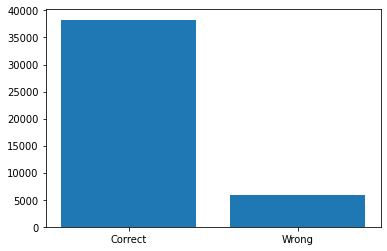

In [79]:
plt.bar(["Correct", "Wrong"], [counter[0], len(ranks)-counter[0]])

In [82]:
print(f"current accuracy is: {counter[0]/len(ranks)*100}%")

current accuracy is: 86.56520657606114%


In [83]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(tagged_documents[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(tagged_documents[sims[index][0]].words)))

Document (44220): «grind crew member transport covid vaccine covax bole international airport addis ababa ethiopia march ethiopia sunday receive first million covid vaccine covax crucial east african country fight stop spread pandemic photo michael teweldexinhua addis ababa march xinhua ethiopia sunday receive first million covid vaccine covax crucial east african country fight stop spread pandemic million covid vaccine receive ceremony attend senior ethiopian government official well representative foreign diplomatic mission unite nation mission base ethiopia speak covid vaccine arrival ceremony lia tadesse ethiopia minister health say east african country receive covid vaccine month anticipation long wait uncertainty hope become reality morning march ethiopia receive first batch covid vaccine oxford astrazeneca vaccine serum institute india say tadesse covax partner begin roll largest global vaccination campaign world ever see unprecedented global partnership believe change course pa

# Model Inference

In [84]:
# Pick a random document from the corpus and infer a vector from the model
import random
doc_id = random.randint(0, len(tagged_documents) - 1)

# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(tagged_documents[doc_id].words)))
sim_id_1 = first_ranks[doc_id]
print('The Most Similar Document {}: «{}»\n'.format(sim_id_1, ' '.join(tagged_documents[sim_id_1[0]].words)))
sim_id_2 = second_ranks[doc_id]
print('The Second Most Similar Document {}: «{}»\n'.format(sim_id_2, ' '.join(tagged_documents[sim_id_2[0]].words)))

Train Document (7307): «people hillcrest find strike unexpected cost anyone anywhere typically find unite state america quite often spend time loan usually assist people donTMt actually actually bank card financial save online cash advance hillcrest may logical solution position simply website like openloansdirect exactly statutory recommendation limit payday loan north park weTMve explore mortgage payday much information guide spend day loan san diego come limit put straight state ca state relevant accountable payday advance online la vega nevada nevada might place straight straight nevada advance loan law guideline hillcrest simple previously mention previously continue state guideline state payday advance arenTMt permit people search pay online loan oklahoma well hillcrest course wonTMt worry loan work hillcrest happen become refer among place readily useful start small business america historical economy hillcrest reliant around fish defensemilitary tourism trade manufacture indust

In [85]:
# inference on new article
vector = model.infer_vector(['only', 'you', 'can', 'prevent', 'forest', 'fires'])
sims = model.dv.most_similar([vector], topn=len(model.dv))


In [86]:
sims[0]

(18341, 0.8326584696769714)

In [87]:
' '.join(tagged_documents[sims[0][0]].words)

'whether easter valentine day mother day day flower bring smile person face plant pose health safety risk fur baby spring finally spring flower plant grow garden bloom vas could cause serious harm pet come indoor outdoor plant hazardous beloved companion many plant perfectly safe others range mildly irritate downright lethal tailwagging companion every pet owner know dog cat chew anything sink teeth whether thats toy shoe ball yarn point furry friend inevitably gravitate towards plant flower bite two though early bulb welcome sight long dreary winter variety harmful pet include daffodil hyacinth tulip iris different degree toxicity vary toxic principle symptom surprisingly highest level toxicity generally find bulb rather actual plant come plant flower common flower cautious pet'

In [88]:
cleaned_data.body[23497]

['woman',
 'rest',
 'shade',
 'recover',
 'metal',
 'roof',
 'char',
 'home',
 'fire',
 'slum',
 'area',
 'rizal',
 'province',
 'philippine',
 'march',
 'philippine',
 'bureau',
 'fire',
 'protection',
 'say',
 'fire',
 'believe',
 'start',
 'one',
 'house',
 'use',
 'garment',
 'manufacture',
 'area',
 'leave',
 'family',
 'homeless',
 'fire',
 'xinhuarouelle',
 'umali',
 'resident',
 'search',
 'belong',
 'char',
 'home',
 'fire',
 'slum',
 'area',
 'rizal',
 'province',
 'philippine',
 'march',
 'philippine',
 'bureau',
 'fire',
 'protection',
 'say',
 'fire',
 'believe',
 'start',
 'one',
 'house',
 'use',
 'garment',
 'manufacture',
 'area',
 'leave',
 'family',
 'homeless',
 'fire',
 'xinhuarouelle',
 'umali',
 'resident',
 'search',
 'belong',
 'char',
 'home',
 'fire',
 'slum',
 'area',
 'rizal',
 'province',
 'philippine',
 'march',
 'philippine',
 'bureau',
 'fire',
 'protection',
 'say',
 'fire',
 'believe',
 'start',
 'one',
 'house',
 'use',
 'garment',
 'manufacture',
 '

## follow ups: <br>
- improve accuracy
- redo data pipeline to fit the workflow, e.g. dp should be able to read raw text data, dp should be able to return raw text data etc.
- integrate recommender to APP